## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
!ros2 topic info /camera_ids/camera_info

Type: sensor_msgs/msg/CameraInfo
Publisher count: 1
Subscription count: 0


In [ ]:
# Training is performed on (3, 518, 518) images
# Evaluation in paper is performed on (3, 518, <some_multiple_of_14>) or (3, <some_multiple_of_14>, 518) with 518 for the smaller dimension and while keeping the original aspect ratio
# Paper states that inference works on other image scales as well (basically as long as dims are multiples of 14?)
shape_original = (1, 3, 1920, 2556)
min_size_resized = 400
base = 14
name_model = "depth_anything_v2_metric_hypersim_vits"


import ros2_monocular_depth.transforms as transforms

shape_input = transforms.resize_shape_to_multiple_of_base(shape_original, min_size_resized=min_size_resized, base=base)
shape_input

(1, 3, 406, 532)

In [5]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_iterations = 100

## Export to ONNX

In [6]:
# Dynamic shapes are currectly not working, so this is currectly not needed
# !pip install onnxscript

In [ ]:
import ros2_monocular_depth.scripts.export_model as export_model

export_model.export_model(name_model, shape_original=shape_original, min_size_resized=min_size_resized, base=base)

## Build engine

In [ ]:
import ros2_monocular_depth.scripts.build_engine as build_engine

build_engine.build_engine(name_model, limit_memory_workspace=1 << 32)

## Data

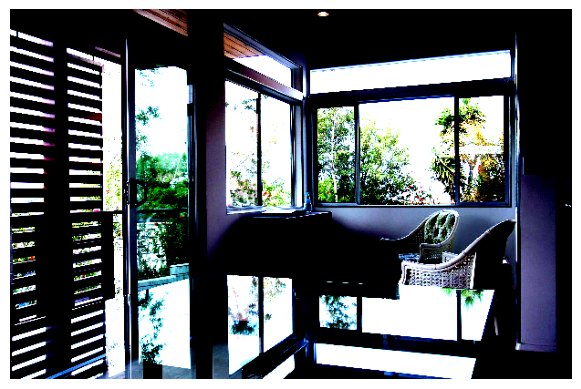

torch.Size([1, 3, 406, 616])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import torchvision.transforms.v2 as tv_transforms

import ros2_monocular_depth.transforms as transforms


modes_image = tv.io.ImageReadMode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = tv_transforms.Compose(
    [
        tv_transforms.PILToTensor(),
        transforms.ResizeToMultipleOfBase(min_size_resized=min_size_resized, base=base, mode_interpolation=transforms.MODES_INTERPOLATION.BICUBIC, use_antialiasing=False),
        tv_transforms.ToDtype(dtype=torch.float32, scale=True),
        tv_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def read_image(path, mode=modes_image.UNCHANGED, use_exif_orientation=False):
    image = tv.io.read_image(path, mode=mode, apply_exif_orientation=use_exif_orientation)
    return image


def visualize_image(image):
    din_a4 = np.array([210, 297]) / 25.4
    fig = plt.figure(figsize=din_a4)

    def subplot_image(image):
        ax = plt.gca()

        ax.set_axis_off()

        image_vis = (np.clip(image, 0.0, 1.0) * 255).astype(np.uint8)
        ax.imshow(image_vis, cmap="viridis" if image.shape[-1] == 1 else None)

    fig.add_subplot(3, 1, 1)
    subplot_image(image)

    plt.tight_layout()
    plt.show()


input = read_image("resources/images/example.jpg")
input = input[None, ...]
input = transform(input)

visualize_image(input[0].numpy().transpose((1, 2, 0)))
print(input.shape)

## Test inference time

### Baseline

In [ ]:
from pathlib import Path

import torchinfo

import ros2_monocular_depth.config as config
from ros2_monocular_depth.models import DepthAnythingV2

name_weights = name_model

path_weights = Path(config._PATH_DIR_WEIGHTS) / f"{name_weights}.pth"
weights = torch.load(f"{path_weights}", map_location="cpu")

model = DepthAnythingV2(**config.MODELS[name_weights]["kwargs"])
model.load_state_dict(weights)
model = model.eval()

try:
    print(torchinfo.summary(model, [input.shape], verbose=0))
except Exception as e:
    print(e)

xFormers not available
xFormers not available


Layer (type:depth-idx)                             Output Shape              Param #
DepthAnythingV2                                    [1, 406, 616]             --
├─DinoVisionTransformer: 1-1                       --                        526,848
│    └─PatchEmbed: 2-1                             [1, 1276, 384]            --
│    │    └─Conv2d: 3-1                            [1, 384, 29, 44]          226,176
│    │    └─Identity: 3-2                          [1, 1276, 384]            --
│    └─ModuleList: 2-2                             --                        --
│    │    └─NestedTensorBlock: 3-3                 [1, 1277, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-4                 [1, 1277, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-5                 [1, 1277, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-6                 [1, 1277, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-7                 [1, 1277, 384]            

In [18]:
with torch.inference_mode():
    input = input.to(device)
    model = model.to(device)

    s = time.time()
    for _ in range(num_iterations):
        output = model(input)
    e = time.time()
    print(num_iterations / (e - s))

    input = input.cpu()
    model = model.cpu()

4.780617857482148


### Compile model with Torch-TensorRT (JIT)

In [ ]:
from pathlib import Path

import torchinfo

import ros2_monocular_depth.config as config
from ros2_monocular_depth.models import DepthAnythingV2

name_weights = name_model

path_weights = Path(config._PATH_DIR_WEIGHTS) / f"{name_weights}.pth"
weights = torch.load(f"{path_weights}", map_location="cpu")

model = DepthAnythingV2(**config.MODELS[name_weights]["kwargs"])
model.load_state_dict(weights)
model = model.eval()

try:
    print(torchinfo.summary(model, [input.shape], verbose=0))
except Exception as e:
    print(e)

INFO:dinov2:using MLP layer as FFN


Layer (type:depth-idx)                             Output Shape              Param #
DepthAnythingV2                                    [1, 518, 798]             --
├─DinoVisionTransformer: 1-1                       --                        526,848
│    └─PatchEmbed: 2-1                             [1, 2109, 384]            --
│    │    └─Conv2d: 3-1                            [1, 384, 37, 57]          226,176
│    │    └─Identity: 3-2                          [1, 2109, 384]            --
│    └─ModuleList: 2-2                             --                        --
│    │    └─NestedTensorBlock: 3-3                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-4                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-5                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-6                 [1, 2110, 384]            1,775,232
│    │    └─NestedTensorBlock: 3-7                 [1, 2110, 384]            

In [9]:
import torch_tensorrt

model_jit = torch.compile(model, backend="tensorrt", options=dict(enabled_precisions={torch.half}, workspace_size=0, optimization_level=5))

print(model_jit)

OptimizedModule(
  (_orig_mod): DepthAnythingV2(
    (pretrained): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-11): 12 x NestedTensorBlock(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=384, out_features=1152, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=384, out_features=384, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=384, out_features=1536, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=1536, out_fea

In [ ]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_jit = model_jit.to(device)

        # Trigger compilation
        output = model_jit(input)

        s = time.time()
        for _ in range(num_iterations):
            output = model_jit(input)
        e = time.time()
        print(num_iterations / (e - s))

        input = input.cpu()
        model_jit = model_jit.cpu()

### Torch-TensorRT (Ahead-of-Time)

In [ ]:
shape_input = (1, 3, 518, 798)

input_dummy = torch.rand(shape_input, device=device, dtype=torch.float32)

# dims = torch.export.dims("height", "width", min=518, max=1036)
# dim_height = torch.export.Dim("height")
# dim_width = torch.export.Dim("width")
# constraints = [
#     dim_height % 14 == 0,
#     dim_width % 14 == 0,
# ]
# torch.export.Constraint()

# exp = torch.export.export(
#     model,
#     (input_dummy,),
#     # dynamic_shapes={"x": {2: dim_height, 3: dim_width}},
#     # constraints=constraints,
# )

# input_dummy = torch_tensorrt.Input(min_shape=[1, 3, 518, 518], opt_shape=[1, 3, 798, 798], max_shape=[1, 3, 1036, 1036], dtype=torch.float32)
# trt_gm = torch_tensorrt.dynamo.compile(exp, inputs=[input_dummy])

path_exported_program = Path(config._PATH_DIR_ENGINES).parent / "exported_programs" / name_model
path_exported_program.parent.mkdir(parents=True, exist_ok=True)

trt_gm = torch_tensorrt.compile(model, ir="default", inputs=[input_dummy], enabled_precisions={torch.float16})
torch_tensorrt.save(trt_gm, path_exported_program, inputs=[input_dummy])

model_aot = torch.export.load(path_exported_program).module()

In [ ]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_aot = model_aot.to(device)

        s = time.time()
        for _ in range(num_iterations):
            output = model_aot(input)
        e = time.time()
        print(num_iterations / (e - s))

        input = input.cpu()
        model_aot = model_aot.cpu()

### TensorRT

In [7]:
!pip install --no-cache-dir /opt/torch2trt

Processing /opt/torch2trt
  Preparing metadata (setup.py) ... done
  Created wheel for torch2trt: filename=torch2trt-0.5.0-py3-none-any.whl size=53583 sha256=1db7ea50feeeff0f0ec1db672d9af163f9dbef6b358ea7ccf0e9d4db539a160c
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbxrd3fs/wheels/2b/d9/e6/a0faeee5b34ac625999e76ad15d3b02c454ff49960cd518ec4
Successfully built torch2trt
  Attempting uninstall: torch2trt
    Found existing installation: torch2trt 0.5.0
    Uninstalling torch2trt-0.5.0:
      Successfully uninstalled torch2trt-0.5.0


In [ ]:
from pathlib import Path
import ros2_monocular_depth.config as config

import tensorrt as trt
from torch2trt import TRTModule

path_engine = Path(config._PATH_DIR_ENGINES) / f"{name_model}.engine"

logger = trt.Logger(trt.Logger.INFO)
runtime = trt.Runtime(logger)

with open(path_engine, "rb") as file_engine:
    engine_serialized = file_engine.read()

engine = runtime.deserialize_cuda_engine(engine_serialized)
engine.get_tensor_shape("input")

model_trt = TRTModule(
    engine=engine,
    input_names=["input"],
    output_names=["output"],
)

[09/27/2024-16:41:51] [TRT] [I] Loaded engine size: 96 MiB
[09/27/2024-16:41:51] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +107, now: CPU 0, GPU 201 (MiB)


In [20]:
from PIL import Image

with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        path_images = Path(".") / "images"
        for path_image in sorted(path_images.iterdir()):
            input = read_image(f"{path_image}")
            input = input[None, ...]
            input = transform(input)

            input = input.to(device)
            model_trt = model_trt.to(device)

            output = model_trt(input)

            output = output[:, None, :, :]
            output = torch.nn.functional.interpolate(output, (shape_original[2], shape_original[3]), mode="bilinear", align_corners=True)
            output = output[0]
            output = output.cpu()
            torch.save(output, f"images_depth/{path_image.stem}.pt")

            input = input.cpu()
            model_trt = model_trt.cpu()

In [19]:
with torch.inference_mode():
    stream = torch.cuda.Stream()
    with torch.cuda.stream(stream):
        input = input.to(device)
        model_trt = model_trt.to(device)

        s = time.time()
        for _ in range(num_iterations):
            output = model_trt(input)
        e = time.time()
        print(num_iterations / (e - s))

        input = input.cpu()
        model_trt = model_trt.cpu()

11.452730968443896


## Without rectification

In [23]:
output = torch.load(f"images_depth/image_013.pt")

torch.Size([1, 1920, 2556])


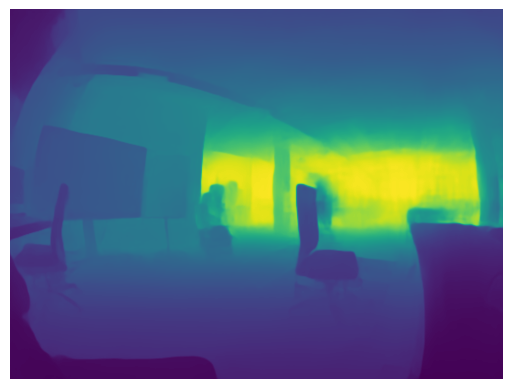

In [24]:
output = output[:, None, :, :]
output = torch.nn.functional.interpolate(output, (shape_original[2], shape_original[3]), mode="bilinear", align_corners=True)
output = output[0]
output = output.cpu()
output = output / output.max()

print(output.shape)
visualize_image(output.numpy().transpose((1, 2, 0)))

## Comparison

torch.Size([1, 1332, 2048])


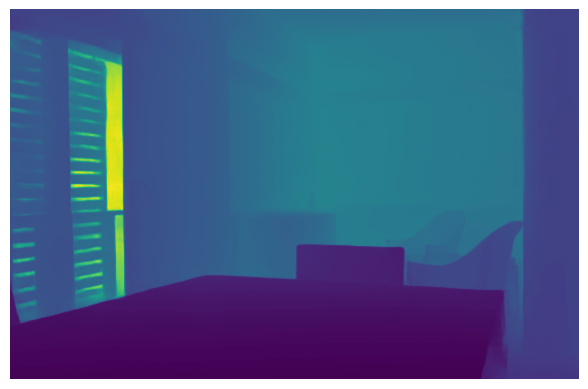

In [17]:
output = output[:, None, :, :]
output = torch.nn.functional.interpolate(output, (shape_original[2], shape_original[3]), mode="bilinear", align_corners=True)
output = output[0]
output = output.cpu()
output = output / output.max()

print(output.shape)
visualize_image(output.numpy().transpose((1, 2, 0)))

torch.Size([1, 1332, 2048])


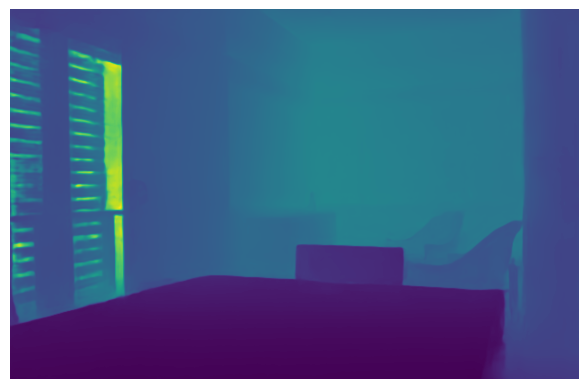

In [14]:
output = output[:, None, :, :]
output = torch.nn.functional.interpolate(output, (shape_original[2], shape_original[3]), mode="bilinear", align_corners=True)
output = output[0]
output = output.cpu()
output = output / output.max()

print(output.shape)
visualize_image(output.numpy().transpose((1, 2, 0)))

## Test transform

In [ ]:
import torchvision.transforms.v2 as tv_transforms
import cv2

import ros2_monocular_depth.models.util.transform as custom_transforms


def transform_original(image_original):
    image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB) / 255.0

    transform = tv_transforms.Compose(
        [
            custom_transforms.Resize(
                width=shape_input[3],
                height=shape_input[2],
                resize_target=False,
                keep_aspect_ratio=True,
                ensure_multiple_of=14,
                resize_method="lower_bound",
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            custom_transforms.NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            custom_transforms.PrepareForNet(),
        ]
    )

    image_original = transform({"image": image_original})["image"]
    image_original = torch.from_numpy(image_original)

    return image_original


image_original = cv2.imread("resources/images/example.jpg")
image_original = transform_original(image_original)

print(torch.allclose(image_original, input[0], atol=0.5, rtol=0.0001))
print(((input[0] - image_original) ** 2).sum())
visualize_image(((input[0] - image_original) ** 2).numpy().transpose((1, 2, 0)))

In [ ]:
stream = torch.cuda.Stream(device=device)

output = torch.ones((1, 160000), device=device)
bindings = [int(input_image.data_ptr()), int(output.data_ptr())]

with engine.create_execution_context() as context:
    context.execute_async_v2(bindings, stream_handle=stream.cuda_stream)
    stream.synchronize()

In [ ]:
depth = output.reshape()

plt.imshow(depth.permute((1, 2, 0)))

In [ ]:
with engine.create_execution_context() as context:

    context.set_tensor_address(name, ptr)
    context.set_input_shape("foo", (3, 150, 250))

    stream = torch.cuda.Stream(device=device)
    context.execute_async_v3(bindings=[int(d_input), int(d_output)], stream_handle=stream.cuda_stream)
    stream.synchronize()

    input_shape = context.get_tensor_shape("input")
    output_shape = context.get_tensor_shape("output")
    h_input = cuda.pagelocked_empty(trt.volume(input_shape), dtype=np.float32)
    h_output = cuda.pagelocked_empty(trt.volume(output_shape), dtype=np.float32)
    d_input = cuda.mem_alloc(h_input.nbytes)
    d_output = cuda.mem_alloc(h_output.nbytes)
    stream = cuda.Stream()

    # Copy the input image to the pagelocked memory
    np.copyto(h_input, input_image.ravel())

    # Copy the input to the GPU, execute the inference, and copy the output back to the CPU
    cuda.memcpy_htod_async(d_input, h_input, stream)
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()
    depth = h_output

    # # Process the depth output
    # depth = np.reshape(depth, output_shape[2:])
    # depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    # depth = depth.astype(np.uint8)
    # depth = cv2.resize(depth, (orig_w, orig_h))

    # # Save the depth map
    # img_name = os.path.basename(args.img)
    # if args.grayscale:
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', depth)
    # else:
    #     colored_depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)
    #     cv2.imwrite(f'{args.outdir}/{img_name[:img_name.rfind(".")]}_depth.png', colored_depth)

In [ ]:
#!trtexec --onnx=resnet50-v1-12.onnx --shapes=data:4x3x224x224 --fp16 --noDataTransfers --useCudaGraph --useSpinWait